# Seam Carving

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Define the energy function

Following the paper (Avidan and Shamir 2007), we decide to use $e_1$ energy which gives good results.

$e_1(I) = |\frac{\partial}{\partial x}I| + |\frac{\partial}{\partial y}I|$ ($I$ represents the image.)

In [64]:
def energy(im):
    """
        input: im, H*W*3 (image with 3 color channels)
        output: energy, H*W
        
        Calculates the 2D energy matrix of the image.
    """
    H, W, C = im.shape
    res = np.zeros((H,W)) # stores the results
    
    fil = np.array([-1,0,1],np.float64)/2 # filter used to calculate the gradient
    
    for i in range(C):
        res += (np.abs(cv2.filter2D(im[:,:,i],-1,fil[np.newaxis,:]))+np.abs(cv2.filter2D(im[:,:,i],-1,fil)))
    
    return res

## Step 2: Find the minimum seams

First, let's consider the top to bottom case.

We use dynamic programming to solve this problem. We record the total energy cost of the path from the top row to the bottom row. Specifically, we start with the top row where the cost is directly adopted from the energy matrix. The second row records the cumulative sum of the first two rows following the below formula.

$Cost_{i,j} = Energy_{i,j} + min(Cost_{i-1,j-1}, Cost_{i-1,j}, Cost_{i-1,j+1})$

The rows further to the bottom are constructed similarly. In the bottom row, whichever cell has the lowest value represents the last pixel of the optimal vertical seam and the path can be easily traced back.

To avoid the zig-zag effect, for any pixel being removed, we only allow one of the **three nearest top neighbors** to be removed and thus we have j-1, j and j+1 in the above formula.

The left to right case can be constructed very similarly.

In [85]:
# set up dynamic programming matrix

def v_cost(energy):
    """
        input: energy matrix, H*W
        output: 
            cost matrix, H*W. Cumulative energy cost from top to bottom. Any pixel is only allowed to 
                              inherit from one of the three nearest top neighbors.
            path matrix, H*W. Each cell records the column index of the prior pixel in the row above
                              (except for cells in the first row).
        
        Calculates the minimum cumulative energy cost of vertical paths and records the optimal paths.
    """
    H, W = energy.shape
    cost = np.zeros((H,W)) # initialize the cost matrix
    path = np.zeros((H,W),dtype=np.uint8) # initialize the path matrix
    
    cost[0,:] = energy[0,:]
    for i in range(1,H):
        for j in range(W):
            if j == 0: # edge case: left-most pixel
                min_cost = np.min([cost[i-1,j],cost[i-1,j+1]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i-1,j]:
                    path[i,j] = j
                else:
                    path[i,j] = j+1
            elif j == W-1: # edge case: right-most pixel
                min_cost = np.min([cost[i-1,j-1],cost[i-1,j]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i-1,j]:
                    path[i,j] = j
                else:
                    path[i,j] = j-1
            else:
                min_cost = np.min([cost[i-1,j-1],cost[i-1,j],cost[i-1,j+1]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i-1,j]:
                    path[i,j] = j
                elif min_cost == cost[i-1,j-1]:
                    path[i,j] = j-1
                else:
                    path[i,j] = j+1
    
    return cost, path

def h_cost(energy):
    """
        TODO
    """
    H, W = energy.shape
    cost = np.zeros((H,W)) # initialize the cost matrix
    path = np.zeros((H,W),dtype=np.uint8) # initialize the path matrix
    
    cost[:,0] = energy[:,0]
    for j in range(1,W):
        for i in range(H):
            if i == 0: # edge case: top-most pixel
                min_cost = np.min([cost[i,j-1],cost[i+1,j-1]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i,j-1]:
                    path[i,j] = i
                else:
                    path[i,j] = i+1
            elif i == H-1: # edge case: bottom-most pixel
                min_cost = np.min([cost[i-1,j-1],cost[i,j-1]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i,j-1]:
                    path[i,j] = i
                else:
                    path[i,j] = i-1
            else:
                min_cost = np.min([cost[i-1,j-1],cost[i,j-1],cost[i+1,j-1]])
                cost[i,j] = energy[i,j] + min_cost
                if min_cost == cost[i,j-1]:
                    path[i,j] = i
                elif min_cost == cost[i-1,j-1]:
                    path[i,j] = i-1
                else:
                    path[i,j] = i+1
    
    return cost, path

In [86]:
# set up masks for carving
def v_mask(cost, path):
    """
        input: cost matrix H*W, path matrix H*W
        output: mask matrix H*W
        
        Calculate mask for vertical seam.
    """
    
    H, W = cost.shape
    mask = np.zeros((H,W)) # initialize mask matrix
    idx = np.argmin(cost[-1,:])
    for i in range(H-1,0,-1):
        mask[i,idx] = 1
        idx = path[i,idx]
    mask[0,idx] = 1
    
    return mask

def h_mask(cost, path):
    """
        input: cost matrix H*W, path matrix H*W
        output: mask matrix H*W
        
        Calculate mask for horizontal seam.
    """
    
    H, W = cost.shape
    mask = np.zeros((H,W)) # initialize mask matrix
    idx = np.argmin(cost[:,-1])
    for j in range(W-1,0,-1):
        mask[idx,j] = 1
        idx = path[idx,j]
    mask[idx,0] = 1
    
    return mask

## Step 3: Generate the result image

Now we just need to take the input image, define the dimension of the output image, and take out vertical and horizontal seams iteratively.

List of images:

    boat: https://pixabay.com/photos/lake-boat-fisher-man-landscape-5000642/

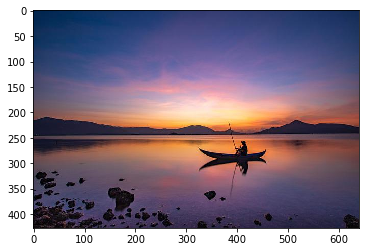

In [145]:
im = cv2.imread("samples/boat.jpg")
plt.imshow(im[:,:,[2,1,0]])

In [146]:
im.shape

(427, 640, 3)

In [99]:
# TODO: why is seam carving so slow? Any chance we could speed it up?

v_cuts: 1/50
v_cuts: 2/50
v_cuts: 3/50
v_cuts: 4/50
v_cuts: 5/50
v_cuts: 6/50
v_cuts: 7/50
v_cuts: 8/50
v_cuts: 9/50
v_cuts: 10/50
v_cuts: 11/50
v_cuts: 12/50
v_cuts: 13/50
v_cuts: 14/50
v_cuts: 15/50
v_cuts: 16/50
v_cuts: 17/50
v_cuts: 18/50
v_cuts: 19/50
v_cuts: 20/50
v_cuts: 21/50
v_cuts: 22/50
v_cuts: 23/50
v_cuts: 24/50
v_cuts: 25/50
v_cuts: 26/50
v_cuts: 27/50
v_cuts: 28/50
v_cuts: 29/50
v_cuts: 30/50
v_cuts: 31/50
v_cuts: 32/50
v_cuts: 33/50
v_cuts: 34/50
v_cuts: 35/50
v_cuts: 36/50
v_cuts: 37/50
v_cuts: 38/50
v_cuts: 39/50
v_cuts: 40/50
v_cuts: 41/50
v_cuts: 42/50
v_cuts: 43/50
v_cuts: 44/50
v_cuts: 45/50
v_cuts: 46/50
v_cuts: 47/50
v_cuts: 48/50
v_cuts: 49/50
v_cuts: 50/50
h_cuts: 1/50
h_cuts: 2/50
h_cuts: 3/50
h_cuts: 4/50
h_cuts: 5/50
h_cuts: 6/50
h_cuts: 7/50
h_cuts: 8/50
h_cuts: 9/50
h_cuts: 10/50
h_cuts: 11/50
h_cuts: 12/50
h_cuts: 13/50
h_cuts: 14/50
h_cuts: 15/50
h_cuts: 16/50
h_cuts: 17/50
h_cuts: 18/50
h_cuts: 19/50
h_cuts: 20/50
h_cuts: 21/50
h_cuts: 22/50
h_cuts: 23

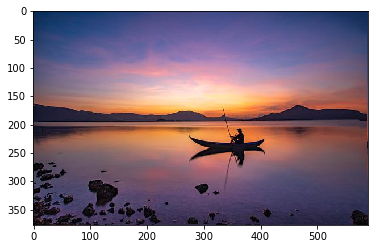

In [147]:
# set up output dimension
output_width = 590
output_height = 377

input_height, input_width, input_channel = im.shape # input shape

v_cuts = input_width - output_width
h_cuts = input_height - output_height

# carve out vertical seams first
for i in range(v_cuts):
    print("v_cuts: {}/{}".format(i+1,v_cuts))
    e = energy(im)
    cost, path = v_cost(e)
    mask = np.repeat((v_mask(cost,path))[:,:,np.newaxis],input_channel,axis=2) # create mask for all channels
    im = im[mask==0].reshape((input_height,input_width-1-i,input_channel))

# carve out horizontal seams next
for i in range(h_cuts):
    print("h_cuts: {}/{}".format(i+1,h_cuts))
    e = energy(im)
    cost, path = h_cost(e)
    mask = np.repeat((h_mask(cost,path))[:,:,np.newaxis],input_channel,axis=2) # create mask for all channels
    im = (im.transpose(1,0,2)[mask.transpose(1,0,2)==0].reshape((output_width,input_height-1-i,input_channel))).transpose(1,0,2)

# show the result
plt.imshow(im[:,:,[2,1,0]])

In [ ]:
#TODO: save each frame of the carving and make videos from it?